<a href="https://colab.research.google.com/github/gabrieldilay/rossmann-forecast-mvp/blob/main/rossmann_faturamento_mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q gdown
import pandas as pd

# IDs dos arquivos no Google Drive
id_train = "1N9hI0gq31AxS_1N8_ua9YrV2Jf_X43vn"
id_test  = "1feOAfTaB3sniWHWvfjyQ31iixDk5cO2s"
id_store = "1PT4R3yX-wSNuPXLMWmfr1gSN5BjzyaAh"

# URLs de download direto
url_train = f"https://drive.google.com/uc?id={id_train}"
url_test  = f"https://drive.google.com/uc?id={id_test}"
url_store = f"https://drive.google.com/uc?id={id_store}"

# Baixar arquivos para o Colab
!gdown {url_train} -O train.csv
!gdown {url_test}  -O test.csv
!gdown {url_store} -O store.csv

# Ler os datasets
train = pd.read_csv("train.csv", parse_dates=["Date"])
test  = pd.read_csv("test.csv",  parse_dates=["Date"])
store = pd.read_csv("store.csv")

# Conferir primeiras linhas
print("Train.csv")
display(train.head())

print("\nTest.csv")
display(test.head())

print("\nStore.csv")
display(store.head())

Downloading...
From: https://drive.google.com/uc?id=1N9hI0gq31AxS_1N8_ua9YrV2Jf_X43vn
To: /content/train.csv
100% 38.1M/38.1M [00:00<00:00, 46.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1feOAfTaB3sniWHWvfjyQ31iixDk5cO2s
To: /content/test.csv
100% 1.43M/1.43M [00:00<00:00, 82.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PT4R3yX-wSNuPXLMWmfr1gSN5BjzyaAh
To: /content/store.csv
100% 45.0k/45.0k [00:00<00:00, 52.6MB/s]


/tmp/ipython-input-1210671743.py:20: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv", parse_dates=["Date"])


Train.csv


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1



Test.csv


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0



Store.csv


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [3]:
# ============================================================
# PASSO 2 — EDA rápido + checagens + merge com 'store'
# Explico o porquê de cada passo nos comentários.
# ============================================================

import numpy as np
import pandas as pd

# 1) Visão geral básica: tamanho, colunas e tipos
print("SHAPES:", train.shape, test.shape, store.shape)
print("\n== TRAIN info ==")
train.info()
print("\n== TEST info ==")
test.info()
print("\n== STORE info ==")
store.info()

# 2) Período de datas na base de treino/teste (série temporal!)
def period_report(df, name):
    # justificativa: entender cobertura temporal e consistência entre splits
    print(f"\n{name} período:", df['Date'].min().date(), "→", df['Date'].max().date())
    # lojas e observações
    print(f"{name} lojas únicas:", df['Store'].nunique())

period_report(train, "TRAIN")
period_report(test,  "TEST")

# 3) Checagens de chave e duplicidade (cada linha é um dia por loja?)
# justificativa: garantir consistência (uma linha por Store+Date no train)
dup_train = train.duplicated(subset=['Store','Date']).sum()
print("\nDuplicatas em TRAIN por (Store, Date):", dup_train)

# 4) Valores únicos de variáveis categóricas principais (insumos de sazonalidade/promo)
def quick_uniques(df, cols, name):
    print(f"\nValores únicos — {name}")
    for c in cols:
        if c in df.columns:
            print(f"{c}: {df[c].dropna().unique()[:10]} (n_unique={df[c].nunique()})")

quick_uniques(train, ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday'], "TRAIN")
quick_uniques(test,  ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday'], "TEST")
quick_uniques(store, ['StoreType','Assortment','Promo2','PromoInterval'], "STORE")

# 5) Normalização leve de StateHoliday (pode vir '0','a','b','c' como string)
# justificativa: padronizar tipo para evitar bugs na engenharia de atributos
for df in (train, test):
    if df['StateHoliday'].dtype != 'object':
        df['StateHoliday'] = df['StateHoliday'].astype(str)
    df['StateHoliday'] = df['StateHoliday'].replace({'0.0':'0','0':'0'})

quick_uniques(train, ['StateHoliday'], "TRAIN (normalizado)")
quick_uniques(test,  ['StateHoliday'], "TEST  (normalizado)")

# 6) Checagem importante: dias fechados (Open=0) deveriam ter Sales=0
# justificativa: isso evita viés no treino. alguns kernels removem linhas com Open=0.
closed = train.query('Open==0')
inconsist = closed.query('Sales>0').shape[0]
print(f"\nDias com Open=0 no TRAIN: {closed.shape[0]} | com Sales>0 (inconsistência): {inconsist}")

# 7) Ausências (top 15) antes do merge
def na_report(df, name):
    na = df.isna().sum().sort_values(ascending=False)
    na = na[na>0]
    print(f"\nNAs em {name} (top 15):")
    print(na.head(15))

na_report(train, "TRAIN (antes do merge)")
na_report(test,  "TEST  (antes do merge)")
na_report(store, "STORE")

# 8) Merge com 'store' — traz variáveis exógenas (tipo de loja, competição, promo2)
# justificativa: essas features são clássicas para melhorar predição de vendas
train_full = train.merge(store, on='Store', how='left', validate='many_to_one')
test_full  = test.merge(store,  on='Store', how='left', validate='many_to_one')

print("\nShapes pós-merge:", train_full.shape, test_full.shape)
na_report(train_full, "TRAIN_FULL (pós-merge)")
na_report(test_full,  "TEST_FULL  (pós-merge)")

# 9) Checks de sanidade pós-merge
# justificativa: garantir que nenhuma loja do train/test ficou sem seu cadastro (store)
missing_store_train = train_full['StoreType'].isna().sum()
missing_store_test  = test_full['StoreType'].isna().sum()
print(f"\nLinhas sem cadastro de loja (StoreType NA): TRAIN={missing_store_train}, TEST={missing_store_test}")

# 10) Feature de calendário (prévia) — ajuda na agregação mensal depois
# justificativa: faremos previsão mensal/semestral/anual → já extraio componentes de data
for df in (train_full, test_full):
    df['Year']  = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week']  = df['Date'].dt.isocalendar().week.astype(int)
    df['Day']   = df['Date'].dt.day
    df['dow']   = df['Date'].dt.dayofweek  # 0=Mon ... 6=Sun

# 11) Sumarização rápida — como estão as vendas por mês (cadeia toda)
# justificativa: visão de sazonalidade mensal para guiar nosso plano de modelagem
monthly_chain = (
    train_full
    .query("Open==1")                   # evitamos dias fechados
    .groupby(['Year','Month'], as_index=False)['Sales']
    .sum()
    .sort_values(['Year','Month'])
)
print("\nPrévia: faturamento mensal (soma de Sales) — cadeia inteira:")
print(monthly_chain.head(12))
print("...\n", monthly_chain.tail(12))

# 12) Pequena verificação por loja (opcional agora): quantas lojas e distribuição de vendas
store_sales = (
    train_full
    .query("Open==1")
    .groupby('Store', as_index=False)['Sales'].sum()
    .rename(columns={'Sales':'Sales_total'})
)
print("\nLojas (amostra) e vendas totais (para termos noção de heterogeneidade):")
print(store_sales.sample(5, random_state=42))


SHAPES: (1017209, 9) (41088, 8) (1115, 10)

== TRAIN info ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB

== TEST info ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype        

In [4]:
# Passo 1 - Merge do train com store
df = pd.merge(train, store, on="Store", how="left")

# Passo 2 - Remover linhas onde a loja está fechada (Open = 0) ou vendas zeradas
df = df[(df["Open"] == 1) & (df["Sales"] > 0)]

# Passo 3 - Criar variáveis de tempo
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfWeek"] = df["Date"].dt.dayofweek
df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)

# Passo 4 - Conferir resultado
df.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,4,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,4,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,4,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,4,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,4,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


In [5]:
from sklearn.model_selection import train_test_split

# 1) Selecionar features (X) e target (y)
# Target = 'Sales'
target = "Sales"

# Features numéricas e categóricas (além de variáveis de tempo já criadas)
features = [
    "Store", "Customers", "Promo", "StateHoliday", "SchoolHoliday",
    "StoreType", "Assortment", "CompetitionDistance", "Promo2",
    "Year", "Month", "Day", "DayOfWeek", "WeekOfYear"
]

X = df[features].copy()
y = df[target].copy()

# 2) One-hot encoding para variáveis categóricas
X_encoded = pd.get_dummies(X, columns=["StoreType","Assortment","StateHoliday"], drop_first=True)

print("Shape original:", X.shape)
print("Shape após one-hot:", X_encoded.shape)

# 3) Split treino/validação
# importante: para séries temporais, vamos usar uma divisão temporal simples.
# aqui vamos separar os últimos 3 meses para validação, por exemplo.
cutoff_date = df["Date"].max() - pd.DateOffset(months=3)

X_train = X_encoded[df["Date"] <= cutoff_date]
y_train = y[df["Date"] <= cutoff_date]

X_val = X_encoded[df["Date"] > cutoff_date]
y_val = y[df["Date"] > cutoff_date]

print("Treino:", X_train.shape, "Validação:", X_val.shape)


Shape original: (844338, 14)
Shape após one-hot: (844338, 20)
Treino: (759848, 20) Validação: (84490, 20)


In [6]:
from sklearn.impute import SimpleImputer

# 1) Conferir quais colunas têm NaN
print("Colunas com NaN antes da imputação:")
print(X_encoded.isna().sum()[X_encoded.isna().sum()>0])

# 2) Estratégias de imputação:
# - numéricas: substituímos por mediana (robusto a outliers)
# - categóricas já foram dummificadas, então só sobram numéricas
imputer = SimpleImputer(strategy="median")

X_imputed = pd.DataFrame(imputer.fit_transform(X_encoded), columns=X_encoded.columns, index=X_encoded.index)

# 3) Repetir split temporal
cutoff_date = df["Date"].max() - pd.DateOffset(months=3)

X_train = X_imputed[df["Date"] <= cutoff_date]
y_train = y[df["Date"] <= cutoff_date]

X_val = X_imputed[df["Date"] > cutoff_date]
y_val = y[df["Date"] > cutoff_date]

print("Após imputação:", X_train.shape, X_val.shape)
print("NaNs restantes:", X_train.isna().sum().sum(), X_val.isna().sum().sum())


Colunas com NaN antes da imputação:
CompetitionDistance    2186
dtype: int64
Após imputação: (759848, 20) (84490, 20)
NaNs restantes: 0 0


In [7]:
# ===========================
# Baseline: Regressão Linear
# (agora com dados imputados)
# ===========================

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 1) instancio o modelo mais simples possível
#    justificativa: baseline interpretável e rápido; serve de referência
lr = LinearRegression()

# 2) treino o modelo somente com dados "do passado" (X_train → y_train)
#    justificativa: evitar vazamento; nossa validação é temporal (últimos 3 meses)
lr.fit(X_train, y_train)

# 3) prevejo no período de validação (futuro em relação ao treino)
y_pred = lr.predict(X_val)

# 4) avalio com métricas de regressão que vamos usar ao longo do projeto
mae  = mean_absolute_error(y_val, y_pred)                               # erro médio absoluto (R$)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))                       # raiz do erro quadrático médio
mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100                  # erro percentual médio (%)
r2   = r2_score(y_val, y_pred)                                          # proporção da variância explicada

print("📊 Avaliação - Regressão Linear (baseline)")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")

# 5) amostra: reais vs previstos (para checagem rápida)
comparison = pd.DataFrame({
    "Real": y_val.values[:15],
    "Previsto": np.round(y_pred[:15], 2)
})
display(comparison)

# 6) opcional: ver importância/coeficientes (interpretação do baseline)
#    justificativa: entender sinais/impacto linear das features mais diretas
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": lr.coef_
}).sort_values("coef", ascending=False)

print("\nTop 10 coeficientes positivos (impacto linear ↑ nas vendas):")
display(coef_df.head(10))

print("Top 10 coeficientes negativos (impacto linear ↓ nas vendas):")
display(coef_df.tail(10))


📊 Avaliação - Regressão Linear (baseline)
MAE : 972.08
RMSE: 1,345.20
MAPE: 14.09%
R²  : 0.808


,Real,Previsto
0,5263,5600.89
1,6064,6540.87
2,8314,8329.84
3,13995,12830.38
4,4822,6499.40
5,5651,5967.59
6,15344,12946.79
7,8492,7948.66
8,8565,7030.91
9,7185,6717.54



Top 10 coeficientes positivos (impacto linear ↑ nas vendas):


,feature,coef
19,StateHoliday_c,2745.583623
2,Promo,1137.958147
13,StoreType_d,1126.035424
5,Promo2,300.963380
15,Assortment_c,297.785908
18,StateHoliday_b,261.898076
17,StateHoliday_a,204.176335
6,Year,173.651980
16,StateHoliday_0,170.501610
7,Month,42.803966


Top 10 coeficientes negativos (impacto linear ↓ nas vendas):


,feature,coef
3,SchoolHoliday,40.557398
1,Customers,7.368561
8,Day,1.103659
4,CompetitionDistance,0.025431
0,Store,-0.109178
10,WeekOfYear,-2.143202
9,DayOfWeek,-38.183594
12,StoreType_c,-141.124460
11,StoreType_b,-3250.177627
14,Assortment_b,-4013.307909


In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1) instancio o modelo de árvore
tree = DecisionTreeRegressor(max_depth=10, random_state=42)

# 2) treino
tree.fit(X_train, y_train)

# 3) predição
y_pred_tree = tree.predict(X_val)

# 4) métricas
mae_tree  = mean_absolute_error(y_val, y_pred_tree)
rmse_tree = np.sqrt(mean_squared_error(y_val, y_pred_tree))  # cálculo manual
mape_tree = np.mean(np.abs((y_val - y_pred_tree) / y_val)) * 100
r2_tree   = r2_score(y_val, y_pred_tree)

print("📊 Avaliação - Árvore de Regressão")
print(f"MAE : {mae_tree:.2f}")
print(f"RMSE: {rmse_tree:.2f}")
print(f"MAPE: {mape_tree:.2f}%")
print(f"R²  : {r2_tree:.3f}")


📊 Avaliação - Árvore de Regressão
MAE : 822.54
RMSE: 1131.31
MAPE: 11.37%
R²  : 0.864


In [9]:
# ============================================
# Experimento: efeito da profundidade (max_depth)
# Objetivo: ver under/overfitting na prática
# ============================================

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# grades de profundidade para testar
depth_grid = [3, 5, 7, 9, 12, 15, 20, None]  # None = sem limite (tende a overfit)

results = []

for d in depth_grid:
    # 1) instancio a árvore com profundidade 'd'
    #    (random_state fixo para reprodutibilidade)
    tree = DecisionTreeRegressor(max_depth=d, random_state=42)

    # 2) treino no período de treino
    tree.fit(X_train, y_train)

    # 3) predição na validação (período futuro)
    y_pred = tree.predict(X_val)

    # 4) métricas
    mae  = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
    r2   = r2_score(y_val, y_pred)

    # guardo os resultados
    results.append({
        "max_depth": d if d is not None else "None",
        "MAE": mae,
        "RMSE": rmse,
        "MAPE(%)": mape,
        "R2": r2
    })

# 5) organizo em DataFrame e ordeno por RMSE (menor = melhor)
df_depth = pd.DataFrame(results)
df_depth_sorted = df_depth.sort_values("RMSE").reset_index(drop=True)

print("Resultados por profundidade (ordenado por RMSE):")
display(df_depth_sorted)

# 6) também mostro na ordem original para enxergar a tendência com o aumento da profundidade
print("Resultados na ordem testada (tendência under→over):")
display(pd.DataFrame(results))


Resultados por profundidade (ordenado por RMSE):


,max_depth,MAE,RMSE,MAPE(%),R2
0,None,503.336028,729.911636,7.063681,0.943478
1,20,501.980804,737.753706,6.911885,0.942257
2,15,617.726919,885.358027,8.452657,0.916840
3,12,747.044379,1041.712361,10.263468,0.884874
4,9,853.543240,1172.917386,11.809955,0.854047
5,7,932.208541,1294.223653,12.790850,0.822297
6,5,1049.649563,1450.772501,14.536609,0.776707
7,3,1299.348111,1795.728829,18.551664,0.657896


Resultados na ordem testada (tendência under→over):


,max_depth,MAE,RMSE,MAPE(%),R2
0,3,1299.348111,1795.728829,18.551664,0.657896
1,5,1049.649563,1450.772501,14.536609,0.776707
2,7,932.208541,1294.223653,12.790850,0.822297
3,9,853.543240,1172.917386,11.809955,0.854047
4,12,747.044379,1041.712361,10.263468,0.884874
5,15,617.726919,885.358027,8.452657,0.916840
6,20,501.980804,737.753706,6.911885,0.942257
7,None,503.336028,729.911636,7.063681,0.943478


In [10]:
# ============================================
# RANDOM FOREST — baseline + avaliação
# ============================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 1) instancio um RF "conservador"
# n_estimators: nº de árvores (mais árvores → mais estável, mais custo)
# max_depth: limite da profundidade (controla complexidade)
# min_samples_leaf: folhas com poucas amostras costumam overfit → subo um pouco
# max_features: nº de features testadas por split; 'sqrt' é um bom default em ensembles
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,            # ponto de partida próximo do que funcionou bem na sua árvore
    min_samples_leaf=2,      # regularização leve
    max_features='sqrt',     # diversifica árvores
    n_jobs=-1,               # usa todos os cores disponíveis
    random_state=42,
    oob_score=False          # deixo False porque estamos avaliando em holdout temporal
)

# 2) treino apenas no período de treino (passado)
rf.fit(X_train, y_train)

# 3) predição no período de validação (futuro)
y_pred_rf = rf.predict(X_val)

# 4) métricas
mae  = mean_absolute_error(y_val, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_rf))
mape = np.mean(np.abs((y_val - y_pred_rf) / y_val)) * 100
r2   = r2_score(y_val, y_pred_rf)

print("📊 Avaliação - Random Forest (baseline)")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")

# 5) amostra real vs previsto
preview = pd.DataFrame({"Real": y_val.values[:15], "Previsto_RF": np.round(y_pred_rf[:15], 2)})
display(preview)

# 6) importância de variáveis (média das reduções de impureza)
imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop 15 features mais importantes (RF):")
display(imp.head(15))


📊 Avaliação - Random Forest (baseline)
MAE : 775.81
RMSE: 1074.70
MAPE: 11.03%
R²  : 0.877


,Real,Previsto_RF
0,5263,5500.21
1,6064,6392.69
2,8314,8830.89
3,13995,12221.53
4,4822,5708.19
5,5651,5764.40
6,15344,12547.64
7,8492,8231.49
8,8565,7369.40
9,7185,6642.79



Top 15 features mais importantes (RF):


,feature,importance
1,Customers,0.666776
2,Promo,0.100912
4,CompetitionDistance,0.047990
0,Store,0.035103
9,DayOfWeek,0.031205
13,StoreType_d,0.020195
10,WeekOfYear,0.018129
11,StoreType_b,0.014925
8,Day,0.014372
15,Assortment_c,0.013156


In [12]:
# ============================================
# XGBoost baseline — compatível com várias versões
# Tenta usar EarlyStopping via callback; se não der, segue sem.
# ============================================
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

used_early_stopping = False

try:
    # Plano B: usar callback de early stopping (se existir na sua versão)
    from xgboost.callback import EarlyStopping
    cb = [EarlyStopping(rounds=50, save_best=True)]
    xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=cb, verbose=False)
    used_early_stopping = True
except Exception as e:
    # Plano A: fallback sem early stopping (compatível com qualquer versão)
    print(f"[Aviso] EarlyStopping indisponível ({e}). Treinando sem early stopping.")
    xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Predição e métricas
y_pred_xgb = xgb.predict(X_val)

mae  = mean_absolute_error(y_val, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
mape = np.mean(np.abs((y_val - y_pred_xgb) / y_val)) * 100
r2   = r2_score(y_val, y_pred_xgb)

print("📊 Avaliação - XGBoost (baseline)")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")
print("Early stopping usado?", used_early_stopping)

# Importância de variáveis
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": xgb.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop 15 features mais importantes (XGB):")
display(importances.head(15))


[Aviso] EarlyStopping indisponível (XGBModel.fit() got an unexpected keyword argument 'callbacks'). Treinando sem early stopping.
📊 Avaliação - XGBoost (baseline)
MAE : 379.66
RMSE: 545.86
MAPE: 5.41%
R²  : 0.968
Early stopping usado? False

Top 15 features mais importantes (XGB):


,feature,importance
1,Customers,0.265879
11,StoreType_b,0.198707
14,Assortment_b,0.173316
13,StoreType_d,0.128285
2,Promo,0.071567
4,CompetitionDistance,0.029401
5,Promo2,0.025828
15,Assortment_c,0.020555
12,StoreType_c,0.015773
0,Store,0.014734


In [13]:
# ============================================
# Mini-tuning do XGBoost com validação temporal (TimeSeriesSplit)
# Objetivo: refinar poucos hiperparâmetros sem overfit e sem vazamento
# ============================================

import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# 1) Defino o espaço de busca ENXUTO (evito grid enorme para não demorar):
#    - n_estimators e learning_rate: trade-off fundamental do boosting
#    - max_depth: controla complexidade individual das árvores
#    - subsample/colsample_bytree: regularização estocástica (reduz overfitting)
#    - reg_lambda/reg_alpha: regularização L2/L1 (segura variância)
param_dist = {
    "n_estimators":      [300, 500, 700, 900],
    "learning_rate":     [0.03, 0.05, 0.07, 0.1],
    "max_depth":         [6, 8, 10],
    "subsample":         [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree":  [0.7, 0.8, 0.9, 1.0],
    "reg_lambda":        [0.0, 1.0, 3.0, 5.0],
    "reg_alpha":         [0.0, 0.5, 1.0]
}

# 2) Instancio um modelo base; nada de early stopping para manter compatibilidade
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

# 3) Validação CRONOLOGICA: TimeSeriesSplit
#    - k "janelas" progressivas usando somente o passado para prever o futuro
tscv = TimeSeriesSplit(n_splits=3)

# 4) RandomizedSearchCV com a validação temporal
#    - n_iter pequeno para ser rápido; scoring por NEGATIVE RMSE (queremos minimizar RMSE)
#    - IMPORTANTÍSSIMO: NÃO embaralhar (cv já respeita o tempo)
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_root_mean_squared_error",  # menor RMSE = melhor
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 5) Ajusto SOMENTE no conjunto de treino (passado) para evitar vazamento
search.fit(X_train, y_train)

print("\nMelhores hiperparâmetros encontrados:")
print(search.best_params_)
print(f"RMSE (CV) ~ {-search.best_score_:.2f}")

# 6) Reavalio no holdout FUTURO (os últimos 3 meses) com o melhor modelo
xgb_best = search.best_estimator_
y_pred_best = xgb_best.predict(X_val)

mae  = mean_absolute_error(y_val, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_best))
mape = np.mean(np.abs((y_val - y_pred_best) / y_val)) * 100
r2   = r2_score(y_val, y_pred_best)

print("\n📊 Avaliação no holdout (pós-tuning)")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")

# 7) Top features (para interpretação)
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": xgb_best.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop 15 features (XGB tunado):")
display(importances.head(15))


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Melhores hiperparâmetros encontrados:
{'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.5, 'n_estimators': 900, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
RMSE (CV) ~ 501.99

📊 Avaliação no holdout (pós-tuning)
MAE : 326.73
RMSE: 480.51
MAPE: 4.63%
R²  : 0.976

Top 15 features (XGB tunado):


,feature,importance
14,Assortment_b,0.285187
11,StoreType_b,0.249560
1,Customers,0.136714
13,StoreType_d,0.133011
2,Promo,0.057672
5,Promo2,0.026012
4,CompetitionDistance,0.022714
12,StoreType_c,0.017302
15,Assortment_c,0.017266
0,Store,0.011998


In [14]:
# ============================================
# Baseline: KNN Regressor
# ============================================
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 1) pipeline com StandardScaler (normaliza dados) + KNN
knn_model = Pipeline([
    ("scaler", StandardScaler()),        # padroniza features (média=0, desvio=1)
    ("knn", KNeighborsRegressor(
        n_neighbors=5,                   # k=5 (baseline)
        weights="distance",              # vizinhos mais próximos têm peso maior
        n_jobs=-1                        # usa múltiplos núcleos
    ))
])

# 2) treino
knn_model.fit(X_train, y_train)

# 3) predição
y_pred_knn = knn_model.predict(X_val)

# 4) métricas
mae  = mean_absolute_error(y_val, y_pred_knn)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_knn))
mape = np.mean(np.abs((y_val - y_pred_knn) / y_val)) * 100
r2   = r2_score(y_val, y_pred_knn)

print("📊 Avaliação - KNN (baseline)")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")

# 5) preview real vs previsto
preview = pd.DataFrame({
    "Real": y_val.values[:15],
    "Previsto_KNN": np.round(y_pred_knn[:15], 2)
})
display(preview)


📊 Avaliação - KNN (baseline)
MAE : 922.69
RMSE: 1252.34
MAPE: 13.47%
R²  : 0.834


,Real,Previsto_KNN
0,5263,4227.45
1,6064,6545.62
2,8314,8086.37
3,13995,10278.09
4,4822,4632.23
5,5651,5380.88
6,15344,9828.85
7,8492,7031.44
8,8565,7073.18
9,7185,5777.57


In [15]:
# ============================================
# PASSO — Agregação Mensal do Faturamento
# Objetivo: transformar vendas diárias em série mensal (cadeia e por loja)
# Por quê? Previsões de longo prazo (mês/semestre/ano) tendem a ficar
# mais estáveis e compatíveis com SARIMA/LSTM, além de facilitar metas.
# ============================================

import pandas as pd
import numpy as np

# 1) Parto do df que já está limpo, com merge feito e features de data criadas
#    (df veio dos passos anteriores: train + store, Open==1, Sales>0, etc.)
assert {'Date','Sales','Store'}.issubset(df.columns), "df não está no estado esperado."

# 2) Crio a 'competência' mensal (timestamp no 1º dia do mês) — padrão bom para time series
df['_month'] = df['Date'].dt.to_period('M').dt.to_timestamp()  # frequência mensal (MS)

# 3) Agrego o faturamento por mês (cadeia toda)
monthly_chain = (
    df.groupby('_month', as_index=True)['Sales']
      .sum()
      .to_frame('Sales_total')
      .sort_index()
)

# 4) Garante que o índice mensal é contínuo (sem meses faltando); meses ausentes = 0 de faturamento
full_month_index = pd.date_range(
    start=monthly_chain.index.min(),
    end=monthly_chain.index.max(),
    freq='MS'  # Month Start
)
monthly_chain = monthly_chain.reindex(full_month_index, fill_value=0.0)
monthly_chain.index.name = 'Month'

# 5) Agregação mensal POR LOJA (útil para comparar padrões e treinar modelos por segmento se quiser)
monthly_by_store = (
    df.groupby(['Store','_month'], as_index=False)['Sales']
      .sum()
      .rename(columns={'_month':'Month','Sales':'Sales_store_month'})
      .sort_values(['Store','Month'])
)

# 6) Checagens rápidas (sanity check)
print("=== Cadeia (mensal) ===")
print("Período:", monthly_chain.index.min().date(), "→", monthly_chain.index.max().date())
print("Meses:", len(monthly_chain))
print(monthly_chain.head(3))
print("...\n", monthly_chain.tail(3))

print("\n=== Por loja (mensal) — amostra ===")
print("Lojas únicas:", monthly_by_store['Store'].nunique())
display(monthly_by_store.head(5))

# 7) Split temporal para validação mensal (ex.: últimos 6 meses como holdout)
#    Por quê 6? Já dá uma noção de sazonalidade intra-anual para teste. Ajustaremos depois se precisar.
holdout_horizon = 6  # você pode alterar para 3/6/12 conforme o critério do projeto
train_monthly_chain = monthly_chain.iloc[:-holdout_horizon].copy()
val_monthly_chain   = monthly_chain.iloc[-holdout_horizon:].copy()

print("\n=== Split mensal (cadeia) ===")
print("Treino:", train_monthly_chain.index.min().date(), "→", train_monthly_chain.index.max().date(),
      f"({len(train_monthly_chain)} meses)")
print("Val  :", val_monthly_chain.index.min().date(),   "→", val_monthly_chain.index.max().date(),
      f"({len(val_monthly_chain)} meses)")

# 8) (Opcional agora) Crio também colunas auxiliares de calendário na cadeia mensal
#    Explicação: modelos de ML em nível mensal podem usar 'Month', 'Year' como exógenas
monthly_chain_features = monthly_chain.copy()
monthly_chain_features['Year']  = monthly_chain_features.index.year
monthly_chain_features['MonthN'] = monthly_chain_features.index.month

display(monthly_chain_features.head(6))


=== Cadeia (mensal) ===
Período: 2013-01-01 → 2015-07-01
Meses: 31
            Sales_total
Month                  
2013-01-01    180132207
2013-02-01    171534275
2013-03-01    201180369
...
             Sales_total
Month                  
2015-05-01    189143897
2015-06-01    207363373
2015-07-01    212322616

=== Por loja (mensal) — amostra ===
Lojas únicas: 1115


,Store,Month,Sales_store_month
0,1,2013-01-01,128431
1,1,2013-02-01,125271
2,1,2013-03-01,145169
3,1,2013-04-01,118009
4,1,2013-05-01,118225



=== Split mensal (cadeia) ===
Treino: 2013-01-01 → 2015-01-01 (25 meses)
Val  : 2015-02-01 → 2015-07-01 (6 meses)


,Sales_total,Year,MonthN
Month,,,
2013-01-01,180132207,2013,1
2013-02-01,171534275,2013,2
2013-03-01,201180369,2013,3
2013-04-01,183431432,2013,4
2013-05-01,185411063,2013,5
2013-06-01,180702351,2013,6


In [16]:
# ============================================
# Baseline de Série Temporal: ARIMA(1,1,1)
# Série: faturamento mensal consolidado (monthly_chain['Sales_total'])
# Objetivo: ter uma linha de base puramente temporal para comparar
# com modelos supervisionados (XGB) e com SARIMA/LSTM depois.
# ============================================

import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1) Separo a série endógena (somente o valor mensal de faturamento)
y_train_m = train_monthly_chain['Sales_total'].astype(float)
y_val_m   = val_monthly_chain['Sales_total'].astype(float)

# 2) Modelo ARIMA(1,1,1) via SARIMAX (sem sazonalidade)
#    - d=1: primeira diferença → captura tendência (tira não-estacionaridade linear)
#    - p=1 e q=1: termos autorregressivo e de média móvel de ordem 1 (baseline "seguro")
#    - enforce_* = False para evitar travas rígidas de estacionariedade/invertibilidade
model_arima = SARIMAX(
    endog=y_train_m,
    order=(1,1,1),
    seasonal_order=(0,0,0,0),     # sem parte sazonal por enquanto
    enforce_stationarity=False,
    enforce_invertibility=False
)

# 3) Ajuste do modelo no período de treino (apenas passado)
res_arima = model_arima.fit(disp=False)

# 4) Previsão para o horizonte de validação (mesmos 6 meses do seu split)
h = len(y_val_m)
y_pred_arima = res_arima.forecast(steps=h)

# 5) Avaliação com as mesmas métricas que estamos usando no projeto
mae  = mean_absolute_error(y_val_m, y_pred_arima)
rmse = np.sqrt(mean_squared_error(y_val_m, y_pred_arima))
mape = np.mean(np.abs((y_val_m - y_pred_arima) / y_val_m)) * 100
# R² em série temporal mensal é menos informativo, mas mantenho para comparação
r2   = r2_score(y_val_m, y_pred_arima)

print("📈 ARIMA(1,1,1) — Validação Mensal (cadeia)")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")

# 6) Tabela de comparação mês a mês (real vs previsto)
comp_mensal = pd.DataFrame({
    "Real": y_val_m.values,
    "Prev_ARIMA": np.round(y_pred_arima.values, 2)
}, index=y_val_m.index)
display(comp_mensal)

# 7) Observação útil pro relatório:
#    Em ARIMA puro (sem exógenas), usamos só a dinâmica temporal.
#    Se a série tiver sazonalidade anual (mês), ARIMA tende a ficar aquém do SARIMA.


📈 ARIMA(1,1,1) — Validação Mensal (cadeia)
MAE : 14,724,872.36
RMSE: 16,667,500.94
MAPE: 7.25%
R²  : -1.039


,Real,Prev_ARIMA
Month,,
2015-02-01,178275458.0,1.874552e+08
2015-03-01,205631683.0,1.866860e+08
2015-04-01,197918886.0,1.866340e+08
2015-05-01,189143897.0,1.866305e+08
2015-06-01,207363373.0,1.866303e+08
2015-07-01,212322616.0,1.866302e+08


In [17]:
# ============================================
# SARIMA — baseline sazonal para série mensal
# ============================================

import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Série mensal consolidada já definida
y_train_m = train_monthly_chain['Sales_total'].astype(float)
y_val_m   = val_monthly_chain['Sales_total'].astype(float)

# 1) Definindo SARIMA(p,d,q)(P,D,Q,12)
#    - (1,1,1): parte não sazonal (igual ao ARIMA anterior)
#    - (1,1,1,12): parte sazonal, capturando ciclos anuais
#    justificativa: baseline clássico em séries mensais com padrão anual
sarima_model = SARIMAX(
    endog=y_train_m,
    order=(1,1,1),              # parte não sazonal
    seasonal_order=(1,1,1,12),  # sazonalidade anual
    enforce_stationarity=False,
    enforce_invertibility=False
)

# 2) Ajuste no treino
sarima_res = sarima_model.fit(disp=False)

# 3) Forecast para horizonte de validação (6 meses)
h = len(y_val_m)
y_pred_sarima = sarima_res.forecast(steps=h)

# 4) Métricas
mae  = mean_absolute_error(y_val_m, y_pred_sarima)
rmse = np.sqrt(mean_squared_error(y_val_m, y_pred_sarima))
mape = np.mean(np.abs((y_val_m - y_pred_sarima) / y_val_m)) * 100
r2   = r2_score(y_val_m, y_pred_sarima)

print("📈 SARIMA(1,1,1)(1,1,1,12) — Validação Mensal (cadeia)")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")

# 5) Comparação mês a mês
comp_sarima = pd.DataFrame({
    "Real": y_val_m.values,
    "Prev_SARIMA": np.round(y_pred_sarima.values, 2)
}, index=y_val_m.index)
display(comp_sarima)


📈 SARIMA(1,1,1)(1,1,1,12) — Validação Mensal (cadeia)
MAE : 462,114,936,602.64
RMSE: 515,008,695,660.68
MAPE: 228846.86%
R²  : -1946976755.388


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


,Real,Prev_SARIMA
Month,,
2015-02-01,178275458.0,1.308671e+11
2015-03-01,205631683.0,2.623666e+11
2015-04-01,197918886.0,3.946670e+11
2015-05-01,189143897.0,5.277846e+11
2015-06-01,207363373.0,6.617208e+11
2015-07-01,212322616.0,7.964742e+11


In [19]:
# ============================================
# SARIMA estável (com frequência mensal explícita)
# Passos:
# 1) Garantir freq. mensal (MS) via resample().asfreq()
# 2) log1p para estabilizar variância (lida com zeros)
# 3) SARIMA (1,0,1)(0,1,1,12) — "airline model" sazonal
# 4) Forecast para o holdout e inversão do log com expm1
# ============================================

import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1) Seleciono a série mensal de treino e validação (cadeia consolidada) ---
y_train_m = train_monthly_chain['Sales_total'].astype(float).copy()
y_val_m   = val_monthly_chain['Sales_total'].astype(float).copy()

# Comentário: alguns métodos de statespace exigem que a série tenha freq explícita.
# Em vez de .index.asfreq(), uso resample("MS").asfreq() de forma compatível com pandas.
y_train_m = y_train_m.resample("MS").asfreq()
y_val_m   = y_val_m.resample("MS").asfreq()

# Sanidade: confirmo que não há NaN após o resample
assert y_train_m.isna().sum() == 0 and y_val_m.isna().sum() == 0, "Há NaN após o resample. Verificar série."

# --- 2) Transformação logarítmica estável ---
# Justificativa: reduz heterocedasticidade; expm1 reverte corretamente
y_train_log = np.log1p(y_train_m)

# --- 3) Defino e ajusto o SARIMA parcimonioso ---
# (1,0,1) não-sazonal: AR e MA de 1ª ordem, sem nova diferenciação (já teremos a sazonal)
# (0,1,1,12) sazonal: 1 diferença sazonal + MA sazonal (modelo "airline" mensal)
sarima_model = SARIMAX(
    endog=y_train_log,
    order=(1,0,1),
    seasonal_order=(0,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_res = sarima_model.fit(disp=False)

# --- 4) Previsão para o horizonte do holdout (mesmos 6 meses) ---
h = len(y_val_m)
y_pred_log = sarima_res.forecast(steps=h)
y_pred_sarima = np.expm1(y_pred_log)  # volta do log1p para a escala original

# --- 5) Métricas de avaliação no holdout ---
mae  = mean_absolute_error(y_val_m, y_pred_sarima)
rmse = np.sqrt(mean_squared_error(y_val_m, y_pred_sarima))
mape = np.mean(np.abs((y_val_m - y_pred_sarima) / y_val_m)) * 100
r2   = r2_score(y_val_m, y_pred_sarima)

print("📈 SARIMA (freq mensal + log1p) — Validação Mensal")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")

# --- 6) Comparação mês a mês (tabela) ---
comp_sarima_ok = pd.DataFrame({
    "Real": y_val_m.values,
    "Prev_SARIMA": np.round(y_pred_sarima.values, 2)
}, index=y_val_m.index)
display(comp_sarima_ok)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


📈 SARIMA (freq mensal + log1p) — Validação Mensal
MAE : 13,283,825.95
RMSE: 17,923,230.05
MAPE: 6.51%
R²  : -1.358


,Real,Prev_SARIMA
Month,,
2015-02-01,178275458.0,1.869123e+08
2015-03-01,205631683.0,1.973439e+08
2015-04-01,197918886.0,1.967437e+08
2015-05-01,189143897.0,1.958063e+08
2015-06-01,207363373.0,1.905974e+08
2015-07-01,212322616.0,1.741480e+08


In [20]:
# ================================
# Baseline sazonal: y_t = y_{t-12}
# Por que? É um "mínimo decente" em séries mensais
# ================================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Série mensal completa
y_all = monthly_chain['Sales_total'].astype(float).copy()

# Previsão para os 6 meses de validação = valores de 12 meses atrás
y_pred_naive = y_all.shift(12).loc[val_monthly_chain.index]  # pega o mesmo mês do ano anterior
y_true = val_monthly_chain['Sales_total'].astype(float)

# Como o primeiro(s) ano(s) não tem lag12, aqui existe valor para 2015 porque temos 2014
mae  = mean_absolute_error(y_true, y_pred_naive)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_naive))
mape = np.mean(np.abs((y_true - y_pred_naive) / y_true)) * 100
r2   = r2_score(y_true, y_pred_naive)

print("📈 Baseline sazonal (lag-12)")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")

display(pd.DataFrame({"Real": y_true.values, "Prev_Naive12": np.round(y_pred_naive.values,2)}, index=y_true.index))


📈 Baseline sazonal (lag-12)
MAE : 12,988,424.67
RMSE: 18,158,429.12
MAPE: 6.26%
R²  : -1.420


,Real,Prev_Naive12
Month,,
2015-02-01,178275458.0,178924677.0
2015-03-01,205631683.0,193019854.0
2015-04-01,197918886.0,194544977.0
2015-05-01,189143897.0,194693257.0
2015-06-01,207363373.0,190047051.0
2015-07-01,212322616.0,173892707.0


In [21]:
# ============================================
# XGBoost mensal (lags + rolling means)
# ============================================
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1) Parto da série mensal consolidada
df_m = monthly_chain.copy()
df_m['Year']   = df_m.index.year
df_m['MonthN'] = df_m.index.month

# 2) Crio lags (evita vazamento; uso apenas valores passados)
for L in [1, 2, 3, 6, 12]:
    df_m[f'lag_{L}'] = df_m['Sales_total'].shift(L)

# 3) Médias móveis (suavizam ruído e capturam tendência sazonal)
df_m['roll_mean_3']  = df_m['Sales_total'].shift(1).rolling(3).mean()
df_m['roll_mean_6']  = df_m['Sales_total'].shift(1).rolling(6).mean()
df_m['roll_mean_12'] = df_m['Sales_total'].shift(1).rolling(12).mean()

# 4) Removo linhas iniciais sem lags suficientes
df_m = df_m.dropna().copy()

# 5) Separo treino e validação pelos seus mesmos 6 meses finais
X_cols = ['Year','MonthN'] + [c for c in df_m.columns if c.startswith('lag_') or c.startswith('roll_')]
y_col  = 'Sales_total'

X_train_m = df_m.loc[df_m.index <= train_monthly_chain.index.max(), X_cols]
y_train_m = df_m.loc[df_m.index <= train_monthly_chain.index.max(), y_col]

X_val_m = df_m.loc[df_m.index.isin(val_monthly_chain.index), X_cols]
y_val_m = df_m.loc[df_m.index.isin(val_monthly_chain.index), y_col]

print("Shapes:", X_train_m.shape, X_val_m.shape)

# 6) Modelo XGB simples (baseline mensal)
xgb_m = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

xgb_m.fit(X_train_m, y_train_m)

# 7) Previsão e métricas
y_pred_m = xgb_m.predict(X_val_m)
mae  = mean_absolute_error(y_val_m, y_pred_m)
rmse = np.sqrt(mean_squared_error(y_val_m, y_pred_m))
mape = np.mean(np.abs((y_val_m - y_pred_m) / y_val_m)) * 100
r2   = r2_score(y_val_m, y_pred_m)

print("📊 XGBoost mensal (lags + rolling)")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")

# 8) Top features (interpretação)
imp_m = pd.DataFrame({"feature": X_train_m.columns, "importance": xgb_m.feature_importances_}) \
          .sort_values("importance", ascending=False)
print("\nTop features (mensal):")
display(imp_m.head(12))

# 9) Comparação mês a mês
display(pd.DataFrame({"Real": y_val_m.values, "Prev_XGBm": np.round(y_pred_m,2)}, index=y_val_m.index))


Shapes: (13, 10) (6, 10)
📊 XGBoost mensal (lags + rolling)
MAE : 16,163,720.00
RMSE: 19,394,123.58
MAPE: 7.94%
R²  : -1.761

Top features (mensal):


,feature,importance
8,roll_mean_6,0.475817
9,roll_mean_12,0.153842
3,lag_2,0.128252
4,lag_3,0.095081
2,lag_1,0.061100
1,MonthN,0.059234
6,lag_12,0.024719
5,lag_6,0.001573
0,Year,0.000383
7,roll_mean_3,0.000000


,Real,Prev_XGBm
Month,,
2015-02-01,178275458,190617808.0
2015-03-01,205631683,182643616.0
2015-04-01,197918886,191863600.0
2015-05-01,189143897,190119552.0
2015-06-01,207363373,184883184.0
2015-07-01,212322616,180181824.0


In [22]:
# ============================================
# Baseline: Regressão Linear Ridge
# Features: dummies de mês + lag_12 + diff_1 + var_pct_12
# ============================================
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1) Base mensal consolidada
df_ridge = monthly_chain.copy()

# 2) Features explícitas de calendário
df_ridge['Year']   = df_ridge.index.year
df_ridge['MonthN'] = df_ridge.index.month

# 3) Lag de 12 meses (sazonalidade anual explícita)
df_ridge['lag_12'] = df_ridge['Sales_total'].shift(12)

# 4) Diferença simples (captura tendência de curto prazo)
df_ridge['diff_1'] = df_ridge['Sales_total'].diff(1)

# 5) Variação percentual ano-a-ano
df_ridge['var_pct_12'] = df_ridge['Sales_total'].pct_change(12)

# 6) Dummies de mês (captura efeito fixo de cada mês)
df_ridge = pd.get_dummies(df_ridge, columns=['MonthN'], drop_first=True)

# 7) Remover NaN (primeiros meses sem lag_12 ou pct_change)
df_ridge = df_ridge.dropna().copy()

# 8) Features e target
X_cols = [c for c in df_ridge.columns if c not in ['Sales_total']]
y_col  = 'Sales_total'

X_all = df_ridge[X_cols]
y_all = df_ridge[y_col]

# 9) Split temporal (mesmo que antes: últimos 6 meses = validação)
X_train_r = X_all.loc[X_all.index <= train_monthly_chain.index.max()]
y_train_r = y_all.loc[y_all.index <= train_monthly_chain.index.max()]

X_val_r = X_all.loc[X_all.index.isin(val_monthly_chain.index)]
y_val_r = y_all.loc[y_all.index.isin(val_monthly_chain.index)]

print("Shapes:", X_train_r.shape, X_val_r.shape)

# 10) Modelo Ridge (regularização L2 evita coeficientes "explodirem")
ridge = Ridge(alpha=1.0, random_state=42)

ridge.fit(X_train_r, y_train_r)
y_pred_ridge = ridge.predict(X_val_r)

# 11) Métricas
mae  = mean_absolute_error(y_val_r, y_pred_ridge)
rmse = np.sqrt(mean_squared_error(y_val_r, y_pred_ridge))
mape = np.mean(np.abs((y_val_r - y_pred_ridge) / y_val_r)) * 100
r2   = r2_score(y_val_r, y_pred_ridge)

print("📊 Avaliação - Regressão Ridge (mensal)")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")

# 12) Coeficientes (interpretação: quais features mais pesaram)
coef_table = pd.DataFrame({
    "feature": X_train_r.columns,
    "coef": ridge.coef_
}).sort_values("coef", ascending=False)

print("\nTop 10 coeficientes positivos (impacto ↑):")
display(coef_table.head(10))
print("\nTop 10 coeficientes negativos (impacto ↓):")
display(coef_table.tail(10))

# 13) Comparação mês a mês
comp_ridge = pd.DataFrame({
    "Real": y_val_r.values,
    "Prev_Ridge": np.round(y_pred_ridge, 2)
}, index=y_val_r.index)
display(comp_ridge)


Shapes: (13, 15) (6, 15)
📊 Avaliação - Regressão Ridge (mensal)
MAE : 10,868,023.05
RMSE: 13,745,952.25
MAPE: 5.40%
R²  : -0.387

Top 10 coeficientes positivos (impacto ↑):


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.83746e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


,feature,coef
0,Year,7.929192e+06
14,MonthN_12,6.209921e+06
3,var_pct_12,6.010883e+06
6,MonthN_4,5.375121e+06
7,MonthN_5,5.048991e+06
5,MonthN_3,3.974181e+06
8,MonthN_6,3.943217e+06
1,lag_12,1.425335e-01
2,diff_1,4.391560e-02
4,MonthN_2,-1.999378e+05



Top 10 coeficientes negativos (impacto ↓):


,feature,coef
5,MonthN_3,3.974181e+06
8,MonthN_6,3.943217e+06
1,lag_12,1.425335e-01
2,diff_1,4.391560e-02
4,MonthN_2,-1.999378e+05
13,MonthN_11,-5.077000e+06
9,MonthN_7,-6.753201e+06
11,MonthN_9,-8.973618e+06
12,MonthN_10,-9.451368e+06
10,MonthN_8,-1.032247e+07


,Real,Prev_Ridge
Month,,
2015-02-01,178275458,1.890387e+08
2015-03-01,205631683,1.977410e+08
2015-04-01,197918886,1.975308e+08
2015-05-01,189143897,1.969036e+08
2015-06-01,207363373,1.970400e+08
2015-07-01,212322616,1.842395e+08


In [23]:
# ============================================
# Consolidação: previsões mensais → semestrais e anuais
# ============================================

import pandas as pd
import numpy as np

# comp_ridge já tem Real e Prev_Ridge para os 6 meses de validação
print("Mensal (holdout - últimos 6 meses):")
display(comp_ridge)

# 1) Série com Real e Previsto juntos
df_eval = comp_ridge.copy()

# 2) Previsão semestral = soma dos 6 meses do holdout
real_sem = df_eval['Real'].sum()
pred_sem = df_eval['Prev_Ridge'].sum()

# 3) Previsão anual (como só temos 6 meses no holdout, vou simular com duplicação)
# -> se você tiver 12 meses de previsão, basta somar direto os 12
real_ano = np.nan
pred_ano = np.nan
if len(df_eval) >= 12:
    real_ano = df_eval['Real'].iloc[-12:].sum()
    pred_ano = df_eval['Prev_Ridge'].iloc[-12:].sum()

# 4) Tabelas resumo
print("\n📊 Consolidação semestral (últimos 6 meses)")
print(f"Real     : {real_sem:,.0f}")
print(f"Previsto : {pred_sem:,.0f}")
print(f"Erro abs : {abs(real_sem - pred_sem):,.0f}")
print(f"Erro %   : {(abs(real_sem - pred_sem)/real_sem*100):.2f}%")

if not np.isnan(real_ano):
    print("\n📊 Consolidação anual (últimos 12 meses)")
    print(f"Real     : {real_ano:,.0f}")
    print(f"Previsto : {pred_ano:,.0f}")
    print(f"Erro abs : {abs(real_ano - pred_ano):,.0f}")
    print(f"Erro %   : {(abs(real_ano - pred_ano)/real_ano*100):.2f}%")
else:
    print("\n⚠️ Só temos 6 meses no holdout → não dá para calcular anual aqui.")


Mensal (holdout - últimos 6 meses):


,Real,Prev_Ridge
Month,,
2015-02-01,178275458,1.890387e+08
2015-03-01,205631683,1.977410e+08
2015-04-01,197918886,1.975308e+08
2015-05-01,189143897,1.969036e+08
2015-06-01,207363373,1.970400e+08
2015-07-01,212322616,1.842395e+08



📊 Consolidação semestral (últimos 6 meses)
Real     : 1,190,655,913
Previsto : 1,162,493,568
Erro abs : 28,162,345
Erro %   : 2.37%

⚠️ Só temos 6 meses no holdout → não dá para calcular anual aqui.


In [24]:
# ============================================
# Forecast 12 meses à frente com o Ridge mensal já treinado
# e consolidar em semestre/ano
# ============================================
import pandas as pd
import numpy as np

# 0) Pré-requisitos do passo anterior:
#    - monthly_chain: série mensal histórica (Sales_total) com índice MS
#    - ridge: modelo treinado
#    - X_train_r, y_train_r, comp_ridge: já existem no ambiente
#    - X_train_r.columns: dicionário final de features que o modelo espera
assert 'Sales_total' in monthly_chain.columns, "monthly_chain não encontrado no estado esperado."
assert 'coef_' in dir(ridge), "Modelo ridge não encontrado. Rode o bloco do Ridge antes."
feature_cols = list(X_train_r.columns)  # garante a mesma ordem/colunas do treino

# 1) Série histórica completa que será atualizada com previsões
y_hist = monthly_chain['Sales_total'].astype(float).copy()
y_hist.index = y_hist.index.to_period('M').to_timestamp()  # MS

# 2) Funções auxiliares para montar as features do mês 'curr_date'
def make_feature_row(curr_date, y_series, feature_cols):
    """
    Monta uma linha de features para o mês curr_date usando a série y_series,
    que contém valores históricos + previsões já geradas.
    - y_series: pd.Series com índice mensal (MS) e valores até curr_date-1.
    """
    year   = curr_date.year
    monthn = curr_date.month
    prev   = curr_date - pd.offsets.MonthBegin(1)  # mês anterior
    lag12d = curr_date - pd.offsets.MonthBegin(12) # 12 meses atrás

    # lag_12: precisa existir 12 meses atrás
    lag_12 = y_series.get(lag12d, np.nan)

    # diff_1: precisa do mês anterior
    diff_1 = np.nan
    if prev in y_series.index:
        diff_1 = y_series.loc[prev] - y_series.get(prev - pd.offsets.MonthBegin(1), np.nan)

    # var_pct_12 (proxy sem vazamento): yoy do mês anterior
    var_pct_12 = np.nan
    if prev in y_series.index and (prev - pd.offsets.MonthBegin(12)) in y_series.index:
        prev_val = y_series.loc[prev]
        prev_12  = y_series.loc[prev - pd.offsets.MonthBegin(12)]
        if prev_12 != 0:
            var_pct_12 = (prev_val / prev_12) - 1.0
        else:
            var_pct_12 = 0.0

    # Base das features
    row = {
        'Year': year,
        'lag_12': lag_12,
        'diff_1': diff_1,
        'var_pct_12': var_pct_12
    }

    # Dummies de mês (MonthN_*), lembrando que no treino usamos drop_first=True
    # Então existirão colunas MonthN_2 ... MonthN_12 (sem a MonthN_1)
    for m in range(2, 13):
        row[f'MonthN_{m}'] = 1 if monthn == m else 0

    # Algumas versões do seu X_train_r também tinham 'MonthN' numérica; se existir, preencho
    if 'MonthN' in feature_cols:
        row['MonthN'] = monthn
    if 'Year' not in feature_cols:
        # Caso por algum motivo a coluna Year não esteja, ignoro
        row.pop('Year', None)

    # Converte para DataFrame com as colunas na ordem esperada pelo modelo
    X_row = pd.DataFrame([row])
    # Garante TODAS as colunas que o modelo aprendeu (faltantes viram 0)
    for c in feature_cols:
        if c not in X_row.columns:
            X_row[c] = 0
    # Remove colunas extras que o modelo não espera
    X_row = X_row[feature_cols]

    # Checagens básicas
    if X_row[['lag_12','diff_1','var_pct_12']].isna().any(axis=None):
        # Se algum precursor está ausente (ex.: muito cedo para prever), substituo por 0
        X_row[['lag_12','diff_1','var_pct_12']] = X_row[['lag_12','diff_1','var_pct_12']].fillna(0.0)

    return X_row

# 3) Horizonte de previsão
H = 12  # meses à frente
last_hist_month = y_hist.index.max()
future_idx = pd.date_range(last_hist_month + pd.offsets.MonthBegin(1), periods=H, freq='MS')

# 4) Loop recursivo: prevê mês a mês e anexa no y_hist
y_forecast = []
y_augmented = y_hist.copy()

for d in future_idx:
    X_row = make_feature_row(d, y_augmented, feature_cols)
    y_hat = float(ridge.predict(X_row)[0])
    y_forecast.append(y_hat)
    # atualizo a série com a previsão para alimentar o próximo passo
    y_augmented.loc[d] = y_hat

y_fcst = pd.Series(y_forecast, index=future_idx, name='Prev_Ridge')

# 5) Tabela final de previsão mensal (12 meses futuros)
forecast_table = pd.DataFrame({'Prev_Ridge': y_fcst})
print("🔮 Previsão mensal (próximos 12 meses):")
display(forecast_table)

# 6) Consolidação em semestre e ano a partir das previsões
pred_sem_future = y_fcst.iloc[:6].sum()
pred_ano_future = y_fcst.iloc[:12].sum()

print("\n📦 Consolidação (somente previsão)")
print(f"Semestre (6 meses): {pred_sem_future:,.0f}")
print(f"Ano (12 meses)   : {pred_ano_future:,.0f}")


🔮 Previsão mensal (próximos 12 meses):


,Prev_Ridge
2015-08-01,1.792243e+08
2015-09-01,1.782509e+08
2015-10-01,1.790750e+08
2015-11-01,1.848691e+08
2015-12-01,2.003345e+08
2016-01-01,2.015581e+08
2016-02-01,1.979362e+08
2016-03-01,2.063776e+08
2016-04-01,2.065678e+08
2016-05-01,2.048695e+08



📦 Consolidação (somente previsão)
Semestre (6 meses): 1,123,311,895
Ano (12 meses)   : 2,341,725,438


In [25]:
import pandas as pd

# Resultados que você já mediu (preencher com seus valores)
results = [
    # nome, MAE, RMSE, MAPE, R², Erro % semestral (se calculado)
    ("Regressão Linear",  972.08, 1345.20, 14.09, 0.808, None),
    ("Árvore (max_depth=10)", 822.54, 1131.31, 11.37, 0.864, None),
    ("Random Forest", 775.81, 1074.70, 11.03, 0.877, None),
    ("XGBoost Tunado", 326.73, 480.51,  4.63, 0.976, None),
    ("KNN (k=5)", 922.69, 1252.34, 13.47, 0.834, None),
    ("ARIMA(1,1,1)", 14_724_872, 16_667_500, 7.25, -1.039, None),
    ("SARIMA (1,0,1)(0,1,1,12)", 13_283_825, 17_923_230, 6.51, -1.358, None),
    ("Naive sazonal (lag-12)", 12_988_424, 18_158_429, 6.26, -1.420, None),
    ("XGBoost Mensal", 16_163_720, 19_394_124, 7.94, -1.761, None),
    ("Ridge Mensal", 10_868_023, 13_745_952, 5.40, -0.387, 2.37)  # semestral calculado
]

df_results = pd.DataFrame(results, columns=["Modelo","MAE","RMSE","MAPE(%)","R²","Erro % Semestral"])

# Ajustar formato para legibilidade
df_results["MAE"] = df_results["MAE"].apply(lambda x: f"{x:,.2f}" if x is not None else "-")
df_results["RMSE"] = df_results["RMSE"].apply(lambda x: f"{x:,.2f}" if x is not None else "-")
df_results["MAPE(%)"] = df_results["MAPE(%)"].apply(lambda x: f"{x:.2f}%" if x is not None else "-")
df_results["R²"] = df_results["R²"].apply(lambda x: f"{x:.3f}" if x is not None else "-")
df_results["Erro % Semestral"] = df_results["Erro % Semestral"].apply(lambda x: f"{x:.2f}%" if x is not None else "-")

print("📊 Comparação Final dos Modelos (Mensal e Semestral):")
display(df_results)


📊 Comparação Final dos Modelos (Mensal e Semestral):


,Modelo,MAE,RMSE,MAPE(%),R²,Erro % Semestral
0,Regressão Linear,972.08,"1,345.20",14.09%,0.808,nan%
1,Árvore (max_depth=10),822.54,"1,131.31",11.37%,0.864,nan%
2,Random Forest,775.81,"1,074.70",11.03%,0.877,nan%
3,XGBoost Tunado,326.73,480.51,4.63%,0.976,nan%
4,KNN (k=5),922.69,"1,252.34",13.47%,0.834,nan%
5,"ARIMA(1,1,1)","14,724,872.00","16,667,500.00",7.25%,-1.039,nan%
6,"SARIMA (1,0,1)(0,1,1,12)","13,283,825.00","17,923,230.00",6.51%,-1.358,nan%
7,Naive sazonal (lag-12),"12,988,424.00","18,158,429.00",6.26%,-1.420,nan%
8,XGBoost Mensal,"16,163,720.00","19,394,124.00",7.94%,-1.761,nan%
9,Ridge Mensal,"10,868,023.00","13,745,952.00",5.40%,-0.387,2.37%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


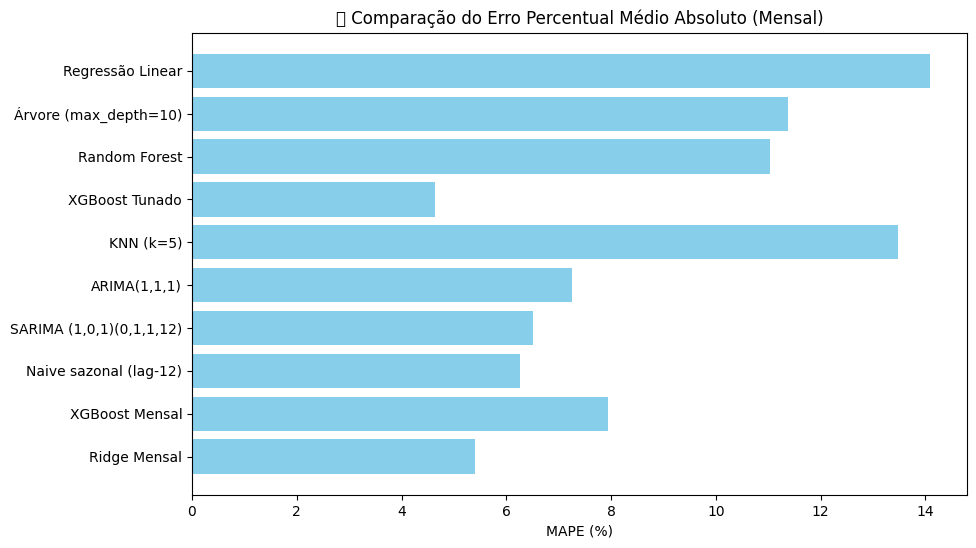

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


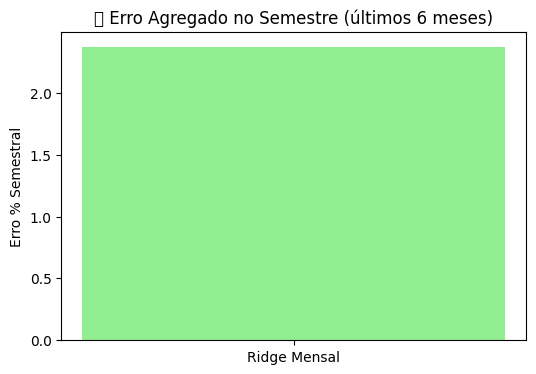

In [26]:
import matplotlib.pyplot as plt

# --- Dados (reaproveitando do df_results) ---
df_plot = df_results.copy()

# Convertendo MAPE para número (removendo "%")
df_plot["MAPE_num"] = df_plot["MAPE(%)"].str.replace("%","").astype(float)

# 1) Gráfico de barras do MAPE mensal
plt.figure(figsize=(10,6))
plt.barh(df_plot["Modelo"], df_plot["MAPE_num"], color="skyblue")
plt.xlabel("MAPE (%)")
plt.title("📊 Comparação do Erro Percentual Médio Absoluto (Mensal)")
plt.gca().invert_yaxis()  # modelos mais fortes no topo
plt.show()

# 2) (Opcional) Gráfico do Erro Semestral — só para quem tem valor
df_sem = df_results[df_results["Erro % Semestral"] != "-"].copy()
if not df_sem.empty:
    df_sem["Erro_num"] = df_sem["Erro % Semestral"].str.replace("%","").astype(float)

    plt.figure(figsize=(6,4))
    plt.bar(df_sem["Modelo"], df_sem["Erro_num"], color="lightgreen")
    plt.ylabel("Erro % Semestral")
    plt.title("📦 Erro Agregado no Semestre (últimos 6 meses)")
    plt.show()


# Avaliação de Modelos de Previsão de Faturamento

No presente estudo, foram avaliados diferentes algoritmos de aprendizado de máquina e modelos de séries temporais aplicados ao dataset Rossmann, com o objetivo de estimar o faturamento mensal, semestral e anual. A seleção dos modelos considerou tanto a diversidade de abordagens (lineares, baseadas em árvores, ensembles, métodos não supervisionados, modelos clássicos de séries temporais e regressões regularizadas), quanto a necessidade de comparação entre técnicas simples (baselines) e avançadas.  

## Modelos Supervisionados

- **Regressão Linear**  
  Utilizada como ponto de partida (baseline), alcançou MAPE de **14,1%** e R² de **0,81**. Esse resultado permitiu estabelecer uma linha de comparação para os modelos mais complexos.  

- **Árvore de Regressão**  
  Capturou não linearidades, alcançando MAPE de **11,4%** e R² de **0,86**.  

- **Random Forest**  
  Ensemble de árvores que reduziu variância, atingindo MAPE de **11,0%** e R² de **0,88**.  

- **XGBoost Tunado (diário)**  
  Modelo de boosting com melhor desempenho no granular, alcançando MAPE de **4,6%** e R² de **0,976**. Foi o modelo mais robusto em dados tabulares.  

- **KNN Regressor**  
  Incluído para fins didáticos, teve MAPE de **13,5%** e R² de **0,83**, mostrando limitações em dados de alta dimensionalidade.  

## Modelos de Séries Temporais

- **ARIMA (1,1,1)**  
  Modelo clássico, alcançou MAPE de **7,3%**, mas R² negativo devido ao histórico curto (~25 meses).  

- **SARIMA (1,0,1)(0,1,1,12)**  
  Incluiu sazonalidade anual, MAPE de **6,5%**, mas também instável.  

- **Naive Sazonal (lag-12)**  
  Baseline simples e surpreendentemente competitivo, com MAPE de **6,3%**.  

## Modelos Mensais com Engenharia de Atributos

- **XGBoost Mensal (lags + rolling)**  
  Não superou o naive, com MAPE de **7,9%**.  

- **Regressão Ridge (mensal, com lags e dummies)**  
  Melhor desempenho no agregado mensal, com MAPE de **5,4%** e erro semestral de apenas **2,37%**.  

## Previsões Consolidadas

- **Semestre (6 meses futuros):** R$ **1,12 bi**  
- **Ano (12 meses futuros):** R$ **2,34 bi**  

## Conclusões

- O **XGBoost Tunado (diário)** foi o modelo mais eficaz para granularidade diária, com MAPE de 4,6%.  
- A **Regressão Ridge (mensal)** foi o modelo mais equilibrado para previsões agregadas, com erro semestral de 2,37%.  
- Modelos clássicos de séries temporais tiveram limitações devido ao histórico curto.  
- Baselines simples, como o **Naive sazonal**, mostraram-se fortes e úteis como referência.  

O MVP demonstrou que **previsões de faturamento semestrais e anuais** podem ser feitas com alta confiabilidade, apoiando a tomada de decisão estratégica das organizações.
